# __Religious Attendance__

### CSS 610 Agent-Based Modeling

#### _Kelby Mace 4/7/2025_

Hardware Platform: Lenovo ThinkPad with AMD Ryzen 7 4700U processor, Radeon Graphics, and 16GB RAM (x64-based architecture).

Operating System: 64-bit Windows OS

Software Development Environment: VS Code Jupyter Notebook extension, Python version 3.10.6

#### __Assumptions:__

1. Social network does not change as a result of an agent's religious participation (or lack thereof).

2. Agents initialized as "religious" have historically attended institution every tick, while agents initialized as secular historically have never attended.

3. Whether someone is considered religious or secular is simply whether they attended that religious institution the previous tick.

4. Agents attend at most one service per tick (they can only be affiliated with one religious institution at a time).

5. Secular agents have a random network with a specifiable number of connections.

#### __Parameters to Analyze:__

1. Strategy distribution:
- 3 Scenarios:
    - Even mix of strategies.
    - No contrarian strategies.
    - Global strategies versus local (concerned with neighbors only).

2. Scale-free vs. small-world (and parameters of each)

3. Initial Conditions (how many are religious / secular at the start)
- 3 Scenarios:
    - 1 Religion, low secular.
    - 1 Religion, no secular.
    - 1 Religion, 50/50.
    - 1 Religion, high secular.

4. Number of inter-faith connections, number of secular connections.

#### __Questions to Ask:__

1. What percent of the population must be "independent fixed" to maintain religious attendance above some level (and under what combination of other conditions)?

2. What percent of the population do you need to have contrarian strategies to maintain oscillation?

3. What conditions sustain some sort of steady state?

4. What conditions lead to (almost) 100% secularization or religiosity?

5. What are the impacts of multiple institutions?

#### __Future Investigation:__

1. Calibrate strategy parameters and probabilities of having a certain strategy (decision-making criteria).

2. Look at the effect of number of religious / secular connections (if one is religious, their network will have more religious people)

3. Look at the effects of weighted decision-making (popular people with high centrality have more of an influence in an agent's decision than others). But they already have a higher influence based on their position in the network...

4. Agent social networks are dynamic (if they go to church, they meet people there)

5. People who make decisions independently

6. Generate agent roles / attributes, such as father, with familial relations...

### __Import Libraries & Define Classes__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import animation
from IPython.display import HTML, display

# __Model Classes__

## __Strategy__

In [2]:
# ------------------------------
# STRATEGY CLASS
# ------------------------------

class Strategy:
    def __init__(self, strategy_type, d, params=None):
        self.strategy_type = strategy_type                  # name of the decision rule
        self.d = d                                          # how many ticks of attendance memory to use (for global strategies)
        self.params = params if params else {}              # any strategy-specific parameters like thresholds, window sizes, etc.

    def score_institution(self, neighbors, attendance_history, religious_state):
        ###   SOCIAL NETWORK FOLLOWER STRATEGIES   ###

        if self.strategy_type == "follow_majority":
            if not neighbors:
                raise ValueError("Agent has 0 neighbors")
            # Get the most recent tick number
            last_tick = max(attendance_history.keys()) - 1 # Subtract one because the current tick is added as an empty list prior to agent decision-making
            neighbors_going = sum(1 for n in neighbors if n in attendance_history[last_tick])
            if neighbors_going / len(neighbors) >= 0.5:
                return neighbors_going # Return number for comparison with other institutions
            else:
                return 0 # If less than half of neighbors went last tick, the agent won't attend this institution

        elif self.strategy_type == "social_majority_recent":
            x = self.params.get("x", 3)
            y = self.params.get("y", 5)
            if not neighbors or len(attendance_history) < y:
                return 0
            # Get the most recent y ticks from attendance_history, sorted by tick number
            recent_ticks = sorted(attendance_history.keys())[-(y + 1):-1] # Subtract one because the current tick is added as an empty list prior to agent decision-making

            # Count how many times each neighbor attended over the recent y ticks
            neighbor_counts = {
                n: sum(n in attendance_history[tick] for tick in recent_ticks)
                for n in neighbors
            }
            going_often = sum(1 for count in neighbor_counts.values() if count >= x)
            if going_often / len(neighbors) >= 0.5:
                return going_often # Return number for comparison with other institutions
            else:
                return 0 # If less than half of neighbors are going often, the agent won't attend this institution

        elif self.strategy_type == "social_trend_following":
            window = self.params.get("window", 4)
            if not neighbors or len(attendance_history) < window + 1:
                return 0
            # Get the most recent `window` ticks in chronological order
            recent_ticks = sorted(attendance_history.keys())[-(window + 1):-1] # Subtract one because the current tick is added as an empty list prior to agent decision-making

            # For each tick, count how many of the agent’s neighbors attended
            trend = [sum(n in attendance_history[tick] for n in neighbors) for tick in recent_ticks]
            slope = np.polyfit(range(window), trend, 1)[0]
            if slope > 0:
                return slope # Return slope to compare and find the institution growing fastest
            else:
                return 0 # If slope is not positive (attendance not increasing) agent won't attend

        elif self.strategy_type == "peer_pressure_threshold":
            window = self.params.get("window", 5)
            threshold = self.params.get("threshold", 0.5)
            if not neighbors or len(attendance_history) < window + 1:
                return 0
            # Get the most recent `window` ticks in chronological order
            recent_ticks = sorted(attendance_history.keys())[-(window + 1):-1]
            total_possible = window * len(neighbors)
            total_attended = sum(1 for tick in recent_ticks for n in neighbors if n in attendance_history[tick])
            if total_attended / total_possible >= threshold:
                return total_attended # Return number to compare with other institutions
            else:
                return 0 # If threshold is not reached, agwent won't attend

        ###   NETWORK CONTRARIAN STRATEGIES   ###

        elif self.strategy_type == "contrarian_follow_minority":
            if not neighbors:
                return 0
            # Get the most recent tick number
            last_tick = max(attendance_history.keys()) - 1 # Subtract one because the current tick is added as an empty list prior to agent decision-making
            neighbors_going = sum(1 for n in neighbors if n in attendance_history[last_tick])
            if neighbors_going / len(neighbors) < 0.5:
                return 10000 - neighbors_going # Return number for comparison with other institutions. Subtract from some arbitrarily large number to invert scalar magnitude to value relationship
            else:
                return 0 # If more than half of neighbors went last tick, the agent won't attend this institution

        elif self.strategy_type == "contrarian_social_minority_recent":
            x = self.params.get("x", 3)
            y = self.params.get("y", 5)
            if not neighbors or len(attendance_history) < y + 1:
                return 0
            # Get the most recent y ticks, sorted by tick number
            recent_ticks = sorted(attendance_history.keys())[-(y + 1):-1] # Subtract one because the current tick is added as an empty list prior to agent decision-making
            # Count how many times each neighbor attended in the last y ticks
            neighbor_counts = {
                n: sum(1 for tick in recent_ticks if n in attendance_history[tick])
                for n in neighbors
            }
            going_often = sum(1 for count in neighbor_counts.values() if count >= x)
            if going_often / len(neighbors) < 0.5:
                return 10000 - going_often # Return number for comparison with other institutions. Subtract from some arbitrarily large number to invert scalar magnitude to value relationship
            else:
                return 0 # If more than half of neighbors are going often, the agent won't attend this institution

        elif self.strategy_type == "contrarian_trend":
            window = self.params.get("window", 4)
            if not neighbors or len(attendance_history) < window + 1:
                return 0
            # Get the most recent `window` ticks in chronological order
            recent_ticks = sorted(attendance_history.keys())[-(window + 1):-1] # Subtract one because the current tick is added as an empty list prior to agent decision-making

            # For each tick, count how many of the agent’s neighbors attended
            trend = [sum(n in attendance_history[tick] for n in neighbors) for tick in recent_ticks]
            slope = np.polyfit(range(window), trend, 1)[0]
            if slope < 0:
                return 10000 - slope # Return slope to compare and find the institution declining fastest. Subtract from some arbitrarily large number to invert scalar magnitude to value relationship
            else:
                return 0 # If slope is positive (attendance increasing) agent won't attend

        elif self.strategy_type == "contrarian_peer_pressure":
            window = self.params.get("window", 5)
            threshold = self.params.get("threshold", 0.5)
            if not neighbors or len(attendance_history) < window + 1:
                return 0
            # Get the most recent `window` ticks in chronological order
            recent_ticks = sorted(attendance_history.keys())[-(window + 1):-1] # Subtract one because the current tick is added as an empty list prior to agent decision-making
            total_possible = window * len(neighbors)
            total_attended = sum(1 for tick in recent_ticks for n in neighbors if n in attendance_history[tick])
            if total_attended / total_possible < threshold:
                return 10000 - total_attended # Return number to compare with other institutions. Subtract from some arbitrarily large number to invert scalar magnitude to value relationship
            else:
                return 0 # If threshold is reached, agent won't attend

        ###   STRATEGIES THAT LOOK AT EVERYONE - NOT JUST NEIGHBORS   ###

        elif self.strategy_type == "global_sheep":
            threshold = self.params.get("global_threshold", 30)
            # Get the most recent tick number
            last_tick = max(attendance_history.keys()) - 1 # Subtract one because the current tick is added as an empty list prior to agent decision-making
            if len(attendance_history[last_tick]) >= threshold:
                return len(attendance_history[last_tick])
            else:
                return 0

        elif self.strategy_type == "global_contrarian":
            threshold = self.params.get("global_threshold", 0.6)
            # Get the most recent tick number
            last_tick = max(attendance_history.keys()) - 1 # Subtract one because the current tick is added as an empty list prior to agent decision-making
            if len(attendance_history[last_tick]) < threshold:
                return 10000 - len(attendance_history[last_tick]) # Subtract from some arbitrarily large number to invert scalar magnitude to value relationship
            else:
                return 0
        elif self.strategy_type == "independent_fixed":
            return 1

        raise KeyError(f"Unknown strategy type: {self.strategy_type}")
        return False
    
# ------------------------------
# STRATEGY GENERATION FUNCTION
# ------------------------------

def generate_strategies(num_strategies, d, N, force_type=None):
    """
    Generate a list of strategies with randomized parameters.

    Parameters:
    - num_strategies: number of Strategy objects to create
    - d: memory length (used by some global strategies)
    - force_type: if set, forces all strategies to be of a single type

    Returns:
    - A list of Strategy instances with parameters preloaded based on the type
    """

    # Define all possible strategy types in the model.
    # These correspond to different decision rules, some network-based, some global, some random.
    strategy_types = [
        "follow_majority",                      # Attend if most neighbors attended last tick
        "social_majority_recent",               # Attend if majority of neighbors went at least x times in last y ticks
        "social_trend_following",               # Attend if there's a positive trend in neighbor attendance
        "peer_pressure_threshold",              # Attend if enough total neighbor attendance across recent ticks
        "contrarian_follow_minority",           # Attend only if minority of neighbors attended last tick
        "contrarian_social_minority_recent",    # Attend if few neighbors attended frequently recently
        "contrarian_trend",                     # Attend if neighbor attendance trend is flat or declining
        "contrarian_peer_pressure",             # Attend if neighbor attendance hasn't crossed a pressure threshold
        "global_sheep",                         # Attend if global attendance has been high recently
        "global_contrarian",                    # Attend if global attendance has been low recently
        "independent_fixed",                    # Keep initial religious state
    ]

    strategies = []  # This will store the Strategy objects created

    for _ in range(num_strategies):
        # Select strategy type:
        # - Use the forced strategy type if one is provided (useful for assigning specific strategies during agent creation)
        # - Otherwise, randomly select one from the full list
        s_type = force_type if force_type else np.random.choice(strategy_types)

        # Initialize a blank params dictionary
        # This will hold the hyperparameters specific to the chosen strategy type
        params = {}

        ###   STRATEGY-SPECIFIC PARAMETERIZATION   ###

        # For recent-majority strategies: define x (number of times attended) and y (how many ticks to look back)
        # Ensure that y >= x, and both values are within [1, 10]
        if s_type in ["social_majority_recent", "contrarian_social_minority_recent"]:
            x = np.random.randint(1, d)        # x is an int within [1, 10]
            y = np.random.randint(x, d)        # y is an int within [x, 10]
            params["x"] = x
            params["y"] = y

        # For trend-following or trend-rejecting strategies: define a lookback window
        elif s_type in ["social_trend_following", "contrarian_trend"]:
            params["window"] = np.random.randint(3, d)  # window size is an int within [3, 5]

        # For threshold strategies: how many ticks to consider, and what % attendance counts as high enough
        elif s_type in ["peer_pressure_threshold", "contrarian_peer_pressure"]:
            params["window"] = np.random.randint(3, d)              # ticks to look back
            params["threshold"] = np.random.uniform(0.3, 0.7)       # threshold for attendance % within [30%, 70%]

        # For global attendance-based strategies: what level of attendance is considered "high" or "low"
        elif s_type in ["global_sheep", "global_contrarian"]:
            params["global_threshold"] = np.random.uniform(0.2*N, 0.8*N)  # threshold is in [20, 80]

        # Create the strategy and add it to the list
        strategies.append(Strategy(s_type, d, params))

    return strategies  # List of fully-initialized Strategy objects

## __Agents__

In [3]:
# ------------------------------
# AGENT CLASS
# ------------------------------

class Agent:
    """
    Represents a single agent in the model.

    Each agent:
    - Has a fixed strategy (defined at init)
    - Belongs to a social network (populated later)
    - May switch institutions tick to tick depending on their strategy
    """

    def __init__(self, agent_id, strategy: Strategy):
        self.id = agent_id                           # Unique ID used for attendance logs and network indexing
        self.strategy = strategy                     # Fixed decision strategy for the agent
        self.religious_state = None                  # Stores the agent's current institution affiliation (None = secular)
        self.religious_history = []                  # tick-by-tick record of where the agent attended (or None)
        self.neighbors = []                          # Filled after network is built — list of other agent IDs

    def set_neighbors(self, neighbor_ids):
        """
        Assigns the social ties for this agent after network construction.
        These are used by network-based decision strategies.
        
        """
        self.neighbors = neighbor_ids

    def choose_institution(self, institutions):
        """

        """
        if self.strategy.strategy_type == 'independent_fixed':
                return self.religious_state
        # Try sticking with the current institution
        if self.religious_state in institutions.keys():
            if self.religious_state != "Secular":
                institution = institutions[self.religious_state]
                attendance_history = institution.attendance_history
                current_score = self.strategy.score_institution(self.neighbors, attendance_history, self.religious_state)
                if current_score > 0:
                    return self.religious_state

        best_score = 0
        best_institution = "Secular"
        # Try switching to another institution if the current one doesn't satisfy
        for institution_id, institution in institutions.items():
            if institution_id == self.religious_state:
                continue  # Already tried this one
            attendance_history = institution.attendance_history
            institution_score = self.strategy.score_institution(self.neighbors, attendance_history, self.religious_state)
            if institution_score > best_score:
                best_score = institution_score
                best_institution = institution_id
        return best_institution  # Found a better fit
    
    def update_religious_state(self, new_state):
        """
        Update the agent’s religious affiliation based on which institution they attended this tick.
        If they didn’t attend a institution, set to None (secular).
        """
        self.religious_state = new_state
        self.religious_history.append(new_state)

## __Religious Institution__

In [4]:
# ------------------------------
# Religious Institution CLASS
# ------------------------------

class ReligiousInstitution:
    """
    Represents a religious institution within the town.
    Tracks its own members, network type, and  attendance history.
    To make the code easier, "Secular" is treated as a Religious Institution object.

    Parameters:
    - institution_id: a unique string identifier (e.g., "Catholic", "Protestant", "Hindu", "Secular")
    - attendance_history: dictionary keyed by tick with list of agent_ids who attended that week as values
    - network_type: type of network to generate for this institution (e.g., small_world, scale_free)

    """

    def __init__(self, institution_id, initial_religious_dict, network_type=None):
        self.id = institution_id

        # Record  attendance: dictionary with tick number as key and a list of agent_ids as values
        self.attendance_history = {}

        # Store the desired network type; fallback to dict if passed
        self.network_type = network_type or initial_religious_dict[institution_id].get("Network Type", "small_world")

## __Model Runner__

In [5]:
# ------------------------------
# MODEL RUNNER CLASS
# ------------------------------

class Model:
    def __init__(self, N, d, initial_religious_dict, strategy_distribution=None, inter_faith_connections=50):
        self.N = N  # Total number of agents in the simulation
        self.d = d  # Memory window (number of initial seeding ticks before simulation begins)
        self.strategy_distribution = strategy_distribution  # Dict of strategy type proportions
        self.initial_religious_dict = initial_religious_dict  # Config dict specifying institution populations and network types
        self.inter_faith_connections = inter_faith_connections # Number of edges to add to the graph outside of institution networks (a measure of religious pluralism / diversity)
        self.agents = []        # List of Agent objects
        self.institutions = {}      # Dict of institution objects, keyed by institution_id (e.g., "Catholic", "Protestant")
        self.G = None           # The full social network (NetworkX Graph)

        self.create_agents()     # Initialize agents with fixed strategies
        self.create_institutions()   # Create Institution objects
        self.assign_agents()     # Assign agents to a faith community (including secular)
        self.build_network()     # Construct the town-wide social network

    def create_agents(self):
        # Step 1: normalize strategy proportions and allocate agents accordingly
        strategy_types = list(self.strategy_distribution.keys())
        proportions = [self.strategy_distribution[stype] for stype in strategy_types]

        if not np.isclose(sum(proportions), 1.0):
            raise ValueError(f"Strategy distribution must sum to 1. Currently: {sum(proportions)}")

        strategy_counts = [int(self.N * p) for p in proportions]
        remainder = self.N - sum(strategy_counts)
        if remainder > 0:
            for i in range(remainder):
                strategy_counts[i % len(strategy_counts)] += 1

        # Step 2: assign strategies to agents
        agent_id = 0
        for stype, count in zip(strategy_types, strategy_counts):
            for _ in range(count):
                strategy = generate_strategies(1, self.d, self.N, force_type=stype)[0] # generates one strategy
                self.agents.append(Agent(agent_id, strategy))
                agent_id += 1

    def create_institutions(self):
        # Initialize ReligiousInstitution objects based on initial religious config
        for faith in self.initial_religious_dict.keys():
            self.institutions[faith] = ReligiousInstitution(faith, self.initial_religious_dict)

    def assign_agents(self):
        """
        Assign every agent to a religious community based on initial_religious_dict.
        Ensures all agents are assigned and institution member lists are properly populated.
        
        """
        assigned_count = 0
        total_needed = sum(config["N"] for config in self.initial_religious_dict.values())

        if total_needed != self.N: # TODO: Remove N at some point, or make proportions instead
            raise ValueError(f"Mismatch: {total_needed} agents defined in religious config but N={self.N}.")

        idx = 0
        for faith, config in self.initial_religious_dict.items():
            for _ in range(config["N"]):
                agent = self.agents[idx]
                agent.institution_id = faith
                agent.religious_state = faith
                idx += 1

    def build_network(self):
        """
        Build a unified social network from per-institution networks and connect secular and cross-faith agents.

        """
        self.G = nx.Graph()

        # First, add every agent as a node (ensures no one is left out)
        for agent in self.agents:
            self.G.add_node(agent.id)

        # Step 1: Internal institution networks (skip Secular initially)
        for institution_id, institution_cfg in self.initial_religious_dict.items():
            if institution_id == "Secular":
                continue  # handle secular agents later

            members = [agent for agent in self.agents if agent.religious_state == institution_id]
            member_ids = [agent.id for agent in members]

            if len(member_ids) < 2:
                continue  # not enough people to form a network

            # Generate institution-specific network based on type
            if institution_cfg["Network Type"] == "small_world":
                n_members = len(member_ids)
                if n_members > 1:
                    k = min(4, n_members - 1)  # k cannot be >= n
                    base_graph = nx.watts_strogatz_graph(n=n_members, k=k, p=0.3)
                else:
                    base_graph = nx.empty_graph(n=n_members)  # Just isolated nodes
            elif institution_cfg["Network Type"] == "scale_free":
                base_graph = nx.barabasi_albert_graph(n=len(member_ids), m=2)
            else:
                raise ValueError(f"Unsupported network type: {institution_cfg['Network Type']}")

            # Relabel with actual agent IDs
            relabeled_graph = nx.relabel_nodes(base_graph, {i: member_ids[i] for i in range(len(member_ids))})

            # Add internal institution edges to main graph
            self.G.add_edges_from(relabeled_graph.edges())

        # Step 2: Add edges from Secular agents to others (religious or secular)
        secular_cfg = self.initial_religious_dict.get("Secular", {})
        initial_connections = secular_cfg.get("Initial Connections", 5)

        secular_agents = [agent for agent in self.agents if agent.religious_state == "Secular"]
        valid_ids = set(agent.id for agent in self.agents)  # Ensure only valid agent IDs are used

        for agent in secular_agents:
            # Possible targets: anyone else except self, and not already connected
            possible_targets = [other.id for other in self.agents if other.id != agent.id and not self.G.has_edge(agent.id, other.id)]

            # Randomly select a subset of targets
            if possible_targets:
                targets = np.random.choice(possible_targets, size=min(initial_connections, len(possible_targets)), replace=False)
                for target_id in targets:
                    if target_id in valid_ids:
                        self.G.add_edge(agent.id, target_id)


        # Step 3: Create inter-faith edges (excluding within the same institution)
        all_ids = [agent.id for agent in self.agents]
        institution_map = {agent.id: agent.religious_state for agent in self.agents}

        added = 0
        attempts = 0
        max_attempts = self.inter_faith_connections * 10  # to avoid infinite loops

        # Add edges between agent nodes by picking two at random (agents can't already be connected to each other, agent can't connect to itself)
        while added < self.inter_faith_connections and attempts < max_attempts:
            a, b = np.random.choice(all_ids, size=2, replace=False)
            if institution_map[a] != institution_map[b] and not self.G.has_edge(a, b):
                self.G.add_edge(a, b)
                added += 1
            attempts += 1

        # Assign social network connections to each agent
        for agent in self.agents:
            agent.set_neighbors(list(self.G.neighbors(agent.id)))

        # Sanity check
        assert len(self.G.nodes) == self.N, f"Graph has {len(self.G.nodes)} nodes but expected {self.N}!"


    def run(self, num_ticks):
        # Phase 1: seed the simulation with d ticks of attendance (religious agents attend)
        for tick in range(self.d):
            for institution in self.institutions.values():
                institution.attendance_history[tick] = []
                for agent in self.agents:
                    if agent.religious_state == institution.id:
                        # print(f"tick: {tick}, Institution: {institution.id}, Agent: {agent.id}")
                        institution.attendance_history[tick].append(agent.id)

        # print(self.institutions["Religious"].attendance_history)
        # Phase 2: simulate agent decisions and track attendance
        for tick in range(self.d, num_ticks + self.d):
            for institution in self.institutions.values():
                institution.attendance_history[tick] = []
            for agent in self.agents:
                # Strategy derermines which institution (if any) to attend
                previous_institution = agent.religious_state
                new_institution = agent.choose_institution(self.institutions)
                # print(f"tick: {tick}, Previous Institution: {previous_institution}, New Institution: {new_institution}, Agent ID: {agent.id}")
                self.institutions[new_institution].attendance_history[tick].append(agent.id) # Add agent to attendance record for their institution of choice

                if previous_institution != new_institution:
                    agent.update_religious_state(new_institution)
            # for institution_id, institution in self.institutions.items():
                # print(f"tick: {tick}, Institution: {institution_id}, Attendance: {len(institution.attendance_history[tick])}")

    def plot_attendance(self):
        """
        Plot attendance over time, broken down by each institution and the secular population.
        Shows how many agents attended each institution each tick, and how many attended none.
        
        """
        plt.figure(figsize=(12, 6))

        # Track attendance per institution by tick
        for institution_id, institution in self.institutions.items():
            # Compute attendance for this institution by tick
            _attendance = []
            for tick, attendance in institution.attendance_history.items():
                if tick >= (self.d-1):
                    _attendance.append(len(attendance))
            plt.plot(_attendance, label=f"{institution_id} Attendance")

        # Plot formatting
        plt.xlabel("Tick")
        plt.ylabel("Number of Attendees")
        plt.title("Attendance by Institution (and Secular)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def get_results(self):
        """
        Summarize the model results with key stats:
        - Mean attendance
        - Variability
        - Final tick's turnout
        """
        global_attendance = {}
        # Track  attendance per institution
        for institution_id, institution in self.institutions.items():
            # Compute  attendance for this institution
            tick_attendance = []
            for tick, attendance in institution.attendance_history.items():
                # if tick > self.d:
                tick_attendance.append(len(attendance))
            global_attendance[institution_id] = tick_attendance
        df = pd.DataFrame(global_attendance)
        df = df.iloc[self.d-1:].reset_index(drop=True) # Leave out the warm-up period
        # display(df.describe())

        return df

    def plot_network(self, layout='spring', node_size=100, with_labels=False, color_by="institution", tick=None):
        """
        Visualize the social network with nodes colored by either:
        - Strategy type (default)
        - Religious state at a specific tick (if color_by="institution")

        Parameters:
        - layout: Node layout ('spring', 'kamada', or 'circular')
        - node_size: Size of nodes
        - with_labels: Whether to display agent IDs
        - color_by: 'strategy' or 'institution'
        - tick: (optional) tick number to color by religious affiliation at that point
        """

        # Color maps depending on the coloring method selected
        strategy_colors = {
            "follow_majority": "blue",
            "social_majority_recent": "orange",
            "social_trend_following": "purple",
            "peer_pressure_threshold": "brown",
            "contrarian_follow_minority": "red",
            "contrarian_social_minority_recent": "pink",
            "contrarian_trend": "skyblue",
            "contrarian_peer_pressure": "gold",
            "global_sheep": "gray",
            "global_contrarian": "green",
            "independent_fixed": "black",
        }

        # Define a basic color list for institutions
        colors = ["blue", "orange", "purple", "green", "brown", "red", "pink", "skyblue", "gold", "gray", "black"]
        institution_colors = {inst_id: colors[i % len(colors)] for i, inst_id in enumerate(self.institutions.keys())}

        # Set the layout
        if layout == 'kamada':
            pos = nx.kamada_kawai_layout(self.G)
        elif layout == 'circular':
            pos = nx.circular_layout(self.G)
        else:
            pos = nx.spring_layout(self.G, seed=42)

        # Determine node colors
        if color_by == "strategy":
            # Color based on strategy types
            node_colors = [strategy_colors.get(agent.strategy.strategy_type, 'black') for agent in self.agents]

        elif color_by == "institution":
            if tick is None:
                # Default: final religious_state
                node_colors = [institution_colors.get(agent.religious_state, "lightgray") for agent in self.agents]
            else:
                # Use religious affiliation at specified tick
                # Construct a lookup: agent ID -> their religion at that tick
                tick_affiliation = {}
                for inst_id, institution in self.institutions.items():
                    if tick < len(institution.attendance_history):
                        attendees = institution.attendance_history[tick]
                        for agent_id in attendees:
                            tick_affiliation[agent_id] = inst_id
                # Now color agents based on their affiliation that tick
                node_colors = [
                    institution_colors.get(tick_affiliation.get(agent.id, None), "lightgray")
                    for agent in self.agents
                ]

        else:
            raise ValueError(f"Invalid color_by option: {color_by}. Must be 'strategy' or 'institution'.")

        # Draw nodes and edges
        nx.draw_networkx_nodes(self.G, pos, node_color=node_colors, node_size=node_size)
        nx.draw_networkx_edges(self.G, pos, alpha=0.3)

        if with_labels:
            labels = {agent.id: agent.id for agent in self.agents}
            nx.draw_networkx_labels(self.G, pos, labels, font_size=8)

        # Create the appropriate legend
        if color_by == "strategy":
            unique_types = sorted(set(agent.strategy.strategy_type for agent in self.agents))
            handles = [
                plt.Line2D([0], [0], marker='o', color='w', label=s,
                        markerfacecolor=strategy_colors.get(s, "black"), markersize=8)
                for s in unique_types
            ]
            legend_title = "Strategy Types"
        else:
            unique_states = sorted(self.institutions.keys())
            handles = [
                plt.Line2D([0], [0], marker='o', color='w', label=rs,
                        markerfacecolor=institution_colors.get(rs, "lightgray"), markersize=8)
                for rs in unique_states
            ]
            legend_title = "Religious State"

        plt.legend(handles=handles, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"Social Network Colored by {color_by.capitalize()} (tick {tick if tick is not None else 'Final'})")
        plt.axis('off')
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Room for legend
        plt.show()


    def animate_attendance(self, interval=500, layout='spring'):
        """
        Create an animated visualization of  attendance.
        Colors are based on religious_state for each agent that tick.
        Legend shows which religion corresponds to which color.
        """
        if not any(inst.attendance_history for inst in self.institutions.values()):
            print("Run the simulation before animating.")
            return

        # Choose network layout
        if layout == 'kamada':
            pos = nx.kamada_kawai_layout(self.G)
        elif layout == 'circular':
            pos = nx.circular_layout(self.G)
        else:
            pos = nx.spring_layout(self.G, seed=42)

        # Assign unique colors to institutions using a colormap
        color_palette = plt.cm.get_cmap("tab10", len(self.institutions) + 1)
        institution_ids = list(self.institutions.keys())
        color_map = {inst: color_palette(i) for i, inst in enumerate(institution_ids)}
        color_map[None] = "gray"  # For secular (non-attending) agents

        # Determine total number of ticks
        total_ticks = len(next(iter(self.institutions.values())).attendance_history)

        fig, ax = plt.subplots(figsize=(8, 6))
        plt.axis('off')

        def update(frame):
            ax.clear()
            plt.axis('off')

            # Build  agent -> religion map
            agent_states = {agent.id: None for agent in self.agents}
            for inst_id, inst in self.institutions.items():
                if frame in inst.attendance_history:
                    for agent_id in inst.attendance_history[frame]:
                        agent_states[agent_id] = inst_id

            # Assign node colors by  religious state
            node_colors = [color_map.get(agent_states[agent.id], "gray") for agent in self.agents]

            # Draw the network
            nx.draw_networkx_nodes(self.G, pos, node_color=node_colors, node_size=120, ax=ax)
            nx.draw_networkx_edges(self.G, pos, ax=ax, alpha=0.3)
            ax.set_title(f"tick {frame + 1} Attendance", fontsize=14)

            # Add legend
            legend_handles = [
                plt.Line2D([0], [0], marker='o', color='w', label=inst if inst else "Secular",
                        markerfacecolor=color_map[inst], markersize=8)
                for inst in color_map
            ]
            # ax.legend(handles=legend_handles, title="Institution", bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.legend(handles=legend_handles, title="Institution", loc='upper left', bbox_to_anchor=(0.8, 0.9))

            # plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room on the right for the legend


        ani = animation.FuncAnimation(
            fig, update,
            frames=total_ticks,
            interval=interval,
            repeat=False
        )

        plt.close()
        return ani

# __Run Model__

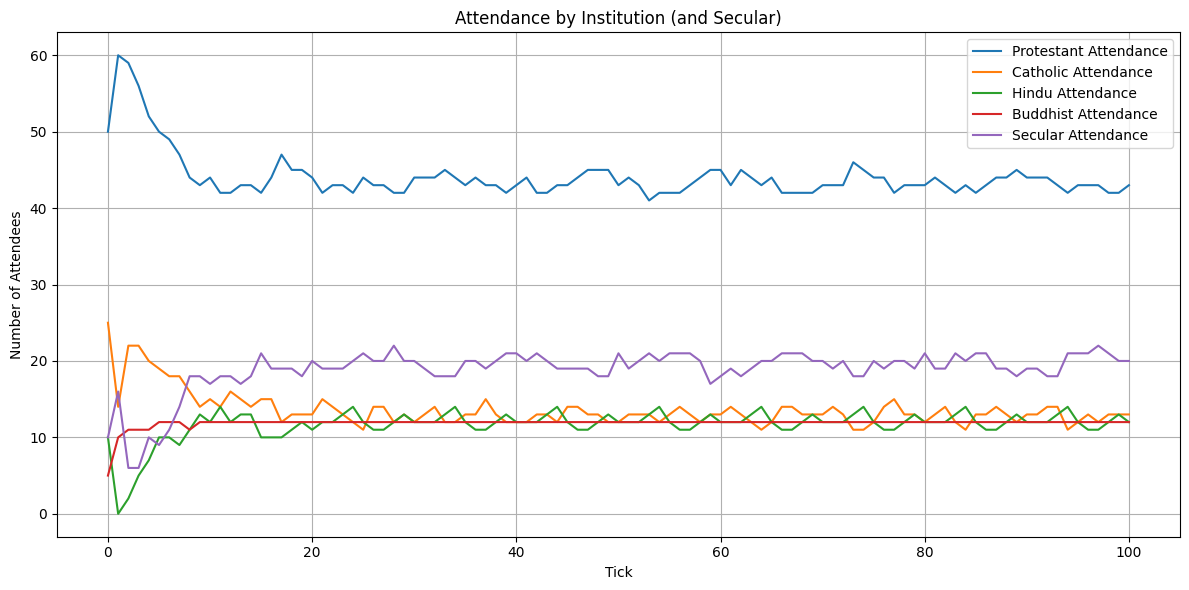

In [11]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                        # Total number of agents
d = 10                          # Memory window for strategies
num_ticks = 100                 # Number of ticks to simulate
inter_faith_connections = 0   # Number of edges added to the graph outside the institution network (a measure of religious pluralism / diversity)
network_type = "scale_free"

# Initial population distribution and network configuration
initial_religious_dict = {
    "Protestant": {"N": 50, "Network Type": network_type},
    "Catholic": {"N": 25, "Network Type": network_type},
    "Hindu": {"N": 10, "Network Type": network_type},
    "Buddhist": {"N": 5, "Network Type": network_type},
    "Secular": {"N": 10, "Initial Connections": 5}
}


# Strategy distribution across the population
strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}


# ------------------------------
# RUN MODEL
# ------------------------------
# Create the model
model = Model(N=N, d=d, initial_religious_dict=initial_religious_dict, strategy_distribution=strategy_distribution, inter_faith_connections=inter_faith_connections)

# Run the simulation
model.run(num_ticks=num_ticks)

# ------------------------------
# STATS & VISUALIZATION
# ------------------------------
# Display overall attendance stats
df = model.get_results()

# Plot total attendance over time
model.plot_attendance()

### __Plot Network by Strategy__

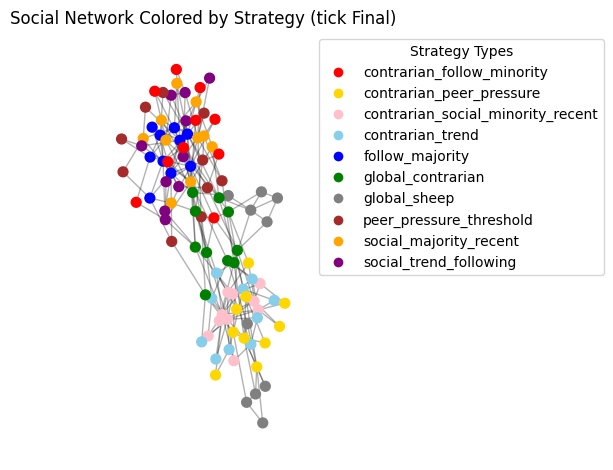

In [12]:
model.plot_network(layout='spring', node_size=50, with_labels=False, color_by="strategy")

### __Plot Network by Religion__

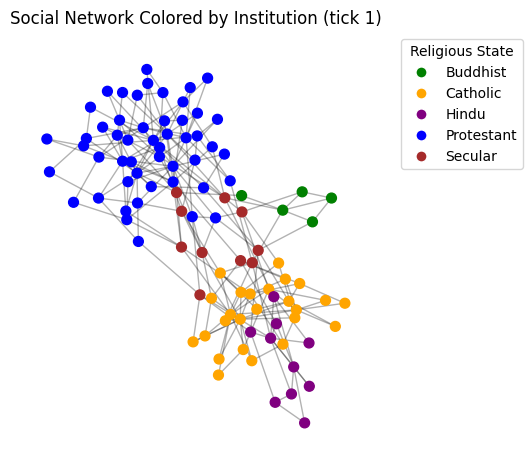

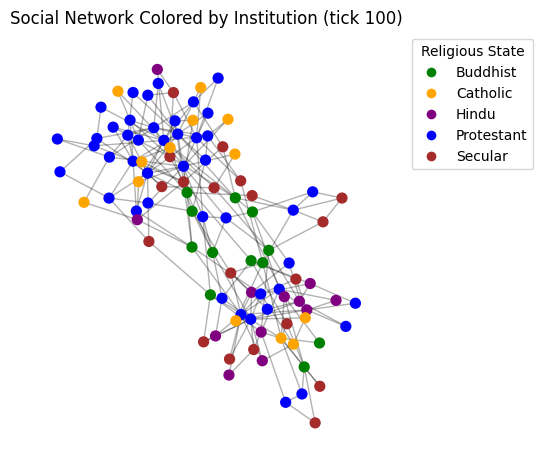

In [13]:
model.plot_network(layout='spring', node_size=50, with_labels=False, tick=1)
model.plot_network(layout='spring', node_size=50, with_labels=False, tick=100)

MovieWriter ffmpeg unavailable; using Pillow instead.


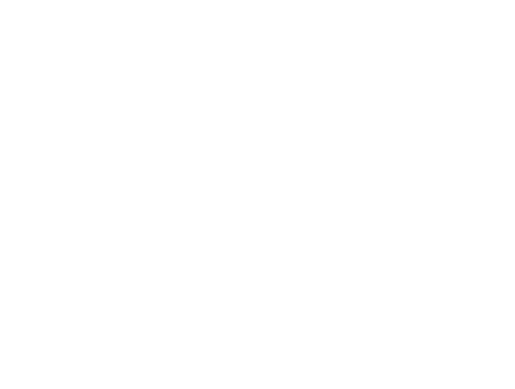

In [14]:
ani = model.animate_attendance(interval=500)
ani.save("Religious Attendance Animation.gif", writer='ffmpeg')

# __Analysis__

## __Strategy Distributions__

#### Scenario 1: Uniform Distribution

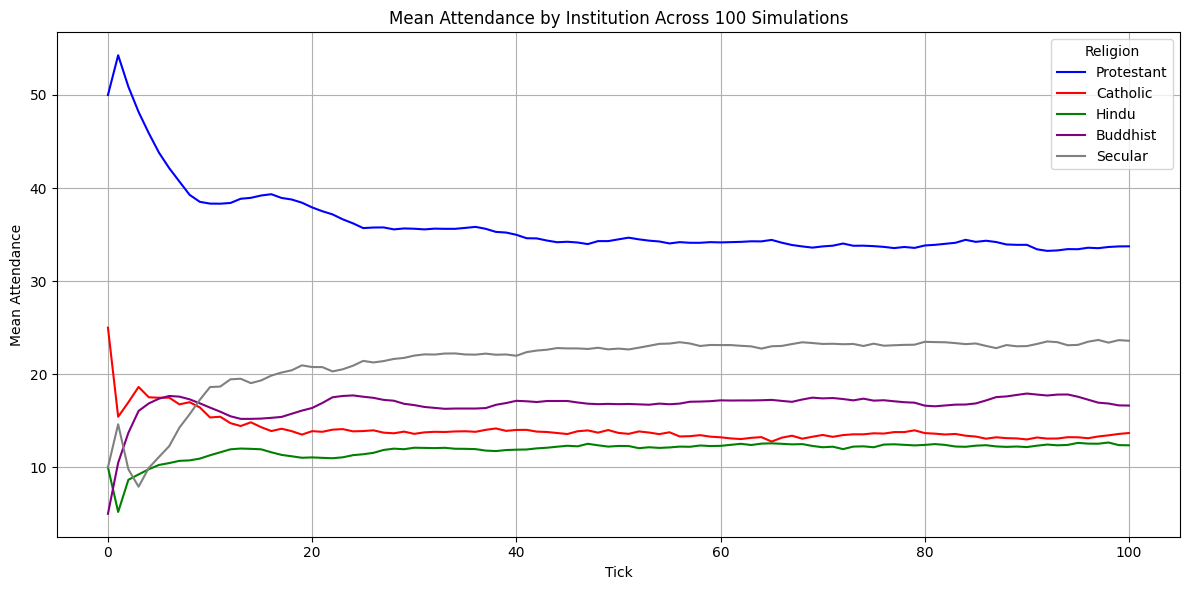

In [43]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                        # Total number of agents
d = 10                          # Memory window for strategies
num_ticks = 100                 # Number of ticks to simulate
inter_faith_connections = 20   # Number of edges added to the graph outside the institution network (a measure of religious pluralism / diversity)
network_type = "small_world"

# Initial population distribution and network configuration
initial_religious_dict = {
    "Protestant": {"N": 50, "Network Type": network_type},
    "Catholic": {"N": 25, "Network Type": network_type},
    "Hindu": {"N": 10, "Network Type": network_type},
    "Buddhist": {"N": 5, "Network Type": network_type},
    "Secular": {"N": 10, "Initial Connections": 5}
}

# Strategy distribution across the population
strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}

num_simulations = 100

# ------------------------------
# SIMULATION LOOP
# ------------------------------
all_attendance = []  # store each run's attendance

for sim in range(num_simulations):
    
    model = Model(
        N=N,
        d=d,
        initial_religious_dict=initial_religious_dict,
        strategy_distribution=strategy_distribution,
        inter_faith_connections=inter_faith_connections
    )
    
    model.run(num_ticks=num_ticks)

    # Grab results — indexed by tick
    attendance_df = model.get_results()
    all_attendance.append(attendance_df)

# ------------------------------
# AGGREGATE RESULTS
# ------------------------------

# Concatenate all runs along a new axis
attendance_concat = np.stack([df.values for df in all_attendance], axis=2)  # Shape: (ticks, religions, runs)

# Take the mean across runs (axis=2)
mean_attendance = np.mean(attendance_concat, axis=2)

# Rebuild into a DataFrame
mean_attendance_df = pd.DataFrame(mean_attendance, columns=all_attendance[0].columns, index=all_attendance[0].index)

# ------------------------------
# PLOT RESULTS
# ------------------------------

religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
plt.figure(figsize=(12, 6))
for religion in mean_attendance_df.columns:
    plt.plot(mean_attendance_df.index, mean_attendance_df[religion], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Tick")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance by Institution Across 100 Simulations")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Scenario 2: Follow Majority Strategies

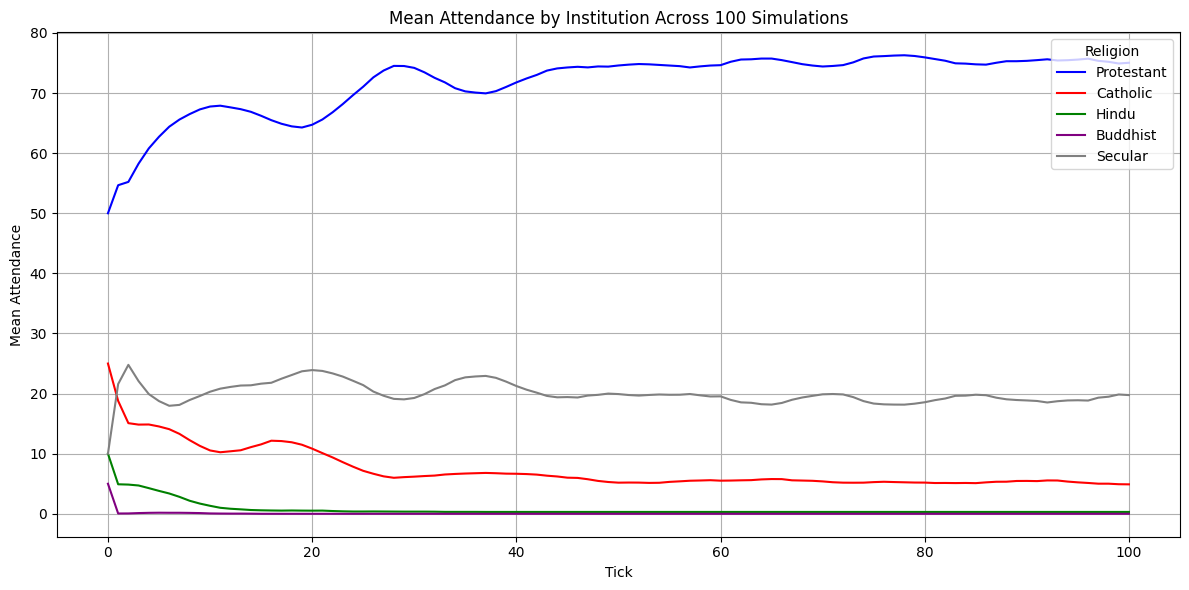

In [44]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                        # Total number of agents
d = 10                          # Memory window for strategies
num_ticks = 100                 # Number of ticks to simulate
inter_faith_connections = 20   # Number of edges added to the graph outside the institution network (a measure of religious pluralism / diversity)
network_type = "small_world"

# Initial population distribution and network configuration
initial_religious_dict = {
    "Protestant": {"N": 50, "Network Type": network_type},
    "Catholic": {"N": 25, "Network Type": network_type},
    "Hindu": {"N": 10, "Network Type": network_type},
    "Buddhist": {"N": 5, "Network Type": network_type},
    "Secular": {"N": 10, "Initial Connections": 5}
}

# Strategy distribution across the population
strategy_distribution = {
    "follow_majority": 0.2,
    "social_majority_recent": 0.2,
    "social_trend_following": 0.2,
    "peer_pressure_threshold": 0.2,
    "contrarian_follow_minority": 0,
    "contrarian_social_minority_recent": 0,
    "contrarian_trend": 0,
    "contrarian_peer_pressure": 0,
    "global_sheep": 0.2,
    "global_contrarian": 0,
    "independent_fixed": 0,
}

num_simulations = 100

# ------------------------------
# SIMULATION LOOP
# ------------------------------
all_attendance = []  # store each run's attendance

for sim in range(num_simulations):
    
    model = Model(
        N=N,
        d=d,
        initial_religious_dict=initial_religious_dict,
        strategy_distribution=strategy_distribution,
        inter_faith_connections=inter_faith_connections
    )
    
    model.run(num_ticks=num_ticks)

    # Grab results — indexed by tick
    attendance_df = model.get_results()
    all_attendance.append(attendance_df)

# ------------------------------
# AGGREGATE RESULTS
# ------------------------------

# Concatenate all runs along a new axis
attendance_concat = np.stack([df.values for df in all_attendance], axis=2)  # Shape: (ticks, religions, runs)

# Take the mean across runs (axis=2)
mean_attendance = np.mean(attendance_concat, axis=2)

# Rebuild into a DataFrame
mean_attendance_df = pd.DataFrame(mean_attendance, columns=all_attendance[0].columns, index=all_attendance[0].index)

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in mean_attendance_df.columns:
    plt.plot(mean_attendance_df.index, mean_attendance_df[religion], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Tick")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance by Institution Across 100 Simulations")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Scenario 3: Contrarian Strategies

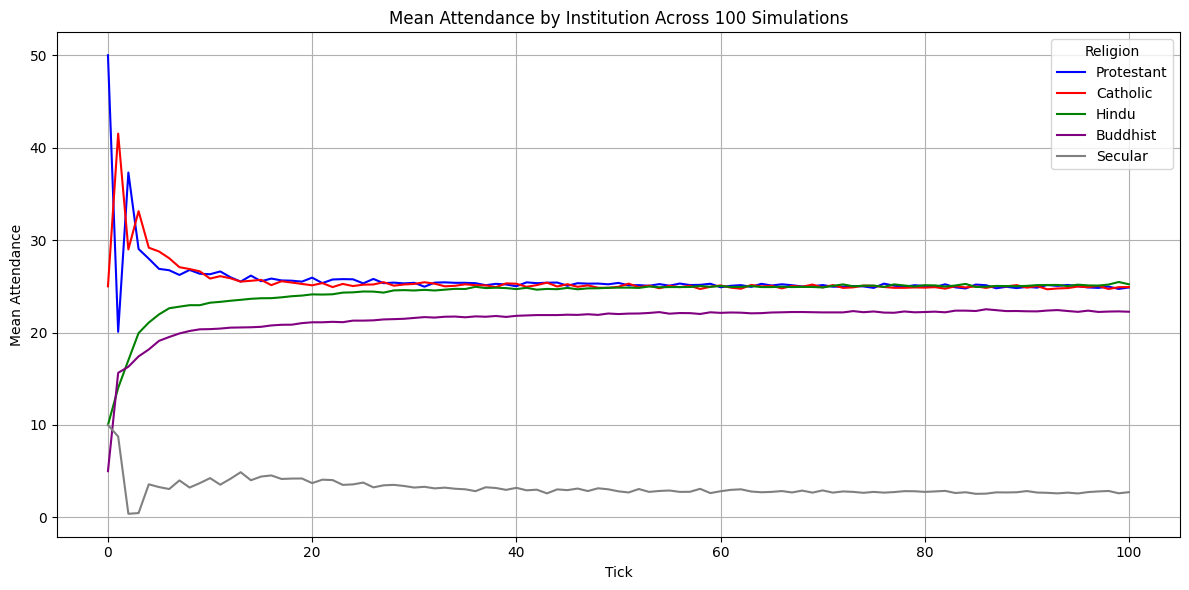

In [45]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                        # Total number of agents
d = 10                          # Memory window for strategies
num_ticks = 100                 # Number of ticks to simulate
inter_faith_connections = 20   # Number of edges added to the graph outside the institution network (a measure of religious pluralism / diversity)
network_type = "small_world"

# Initial population distribution and network configuration
initial_religious_dict = {
    "Protestant": {"N": 50, "Network Type": network_type},
    "Catholic": {"N": 25, "Network Type": network_type},
    "Hindu": {"N": 10, "Network Type": network_type},
    "Buddhist": {"N": 5, "Network Type": network_type},
    "Secular": {"N": 10, "Initial Connections": 5}
}

# Strategy distribution across the population
strategy_distribution = {
    "follow_majority": 0,
    "social_majority_recent": 0,
    "social_trend_following": 0,
    "peer_pressure_threshold": 0,
    "contrarian_follow_minority": 0.2,
    "contrarian_social_minority_recent": 0.2,
    "contrarian_trend": 0.2,
    "contrarian_peer_pressure": 0.2,
    "global_sheep": 0,
    "global_contrarian": 0.2,
    "independent_fixed": 0,
}

num_simulations = 100

# ------------------------------
# SIMULATION LOOP
# ------------------------------
all_attendance = []  # store each run's attendance

for sim in range(num_simulations):
    
    model = Model(
        N=N,
        d=d,
        initial_religious_dict=initial_religious_dict,
        strategy_distribution=strategy_distribution,
        inter_faith_connections=inter_faith_connections
    )
    
    model.run(num_ticks=num_ticks)

    # Grab results — indexed by tick
    attendance_df = model.get_results()
    all_attendance.append(attendance_df)

# ------------------------------
# AGGREGATE RESULTS
# ------------------------------

# Concatenate all runs along a new axis
attendance_concat = np.stack([df.values for df in all_attendance], axis=2)  # Shape: (ticks, religions, runs)

# Take the mean across runs (axis=2)
mean_attendance = np.mean(attendance_concat, axis=2)

# Rebuild into a DataFrame
mean_attendance_df = pd.DataFrame(mean_attendance, columns=all_attendance[0].columns, index=all_attendance[0].index)

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in mean_attendance_df.columns:
    plt.plot(mean_attendance_df.index, mean_attendance_df[religion], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Tick")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance by Institution Across 100 Simulations")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Scenario 4: Global Strategies

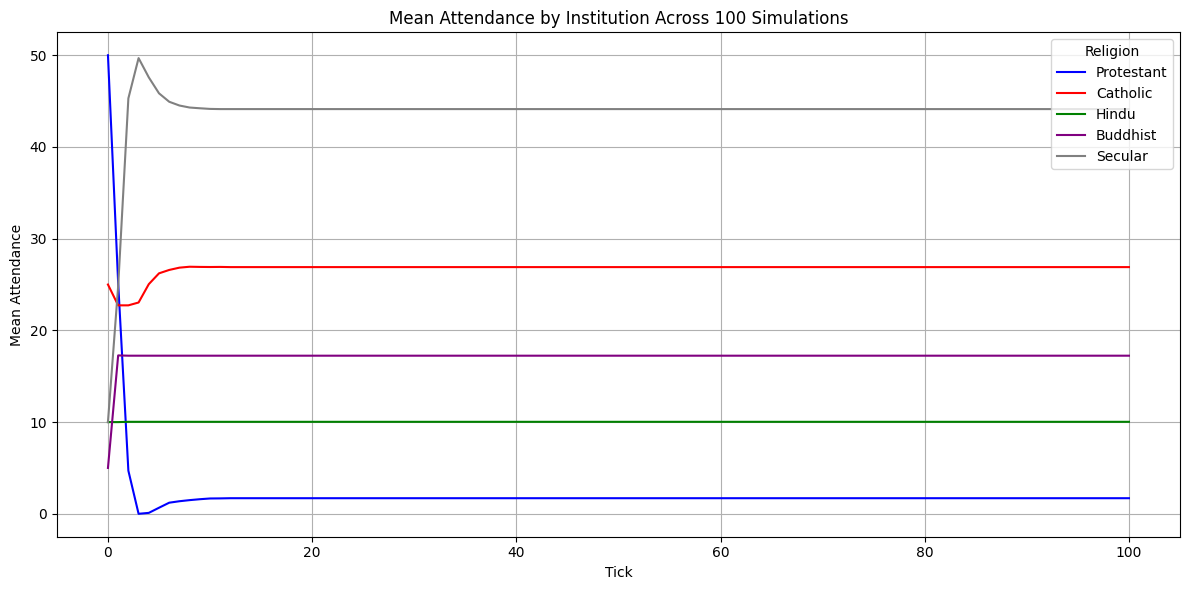

In [46]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                        # Total number of agents
d = 10                          # Memory window for strategies
num_ticks = 100                 # Number of ticks to simulate
inter_faith_connections = 20   # Number of edges added to the graph outside the institution network (a measure of religious pluralism / diversity)
network_type = "small_world"

# Initial population distribution and network configuration
initial_religious_dict = {
    "Protestant": {"N": 50, "Network Type": network_type},
    "Catholic": {"N": 25, "Network Type": network_type},
    "Hindu": {"N": 10, "Network Type": network_type},
    "Buddhist": {"N": 5, "Network Type": network_type},
    "Secular": {"N": 10, "Initial Connections": 5}
}

# Strategy distribution across the population
strategy_distribution = {
    "follow_majority": 0,
    "social_majority_recent": 0,
    "social_trend_following": 0,
    "peer_pressure_threshold": 0,
    "contrarian_follow_minority": 0,
    "contrarian_social_minority_recent": 0,
    "contrarian_trend": 0,
    "contrarian_peer_pressure": 0,
    "global_sheep": 0.5,
    "global_contrarian": 0.5,
    "independent_fixed": 0,
}

num_simulations = 100

# ------------------------------
# SIMULATION LOOP
# ------------------------------
all_attendance = []  # store each run's attendance

for sim in range(num_simulations):
    
    model = Model(
        N=N,
        d=d,
        initial_religious_dict=initial_religious_dict,
        strategy_distribution=strategy_distribution,
        inter_faith_connections=inter_faith_connections
    )
    
    model.run(num_ticks=num_ticks)

    # Grab results — indexed by tick
    attendance_df = model.get_results()
    all_attendance.append(attendance_df)

# ------------------------------
# AGGREGATE RESULTS
# ------------------------------

# Concatenate all runs along a new axis
attendance_concat = np.stack([df.values for df in all_attendance], axis=2)  # Shape: (ticks, religions, runs)

# Take the mean across runs (axis=2)
mean_attendance = np.mean(attendance_concat, axis=2)

# Rebuild into a DataFrame
mean_attendance_df = pd.DataFrame(mean_attendance, columns=all_attendance[0].columns, index=all_attendance[0].index)

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in mean_attendance_df.columns:
    plt.plot(mean_attendance_df.index, mean_attendance_df[religion], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Tick")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance by Institution Across 100 Simulations")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Scenario 5: Local Strategies

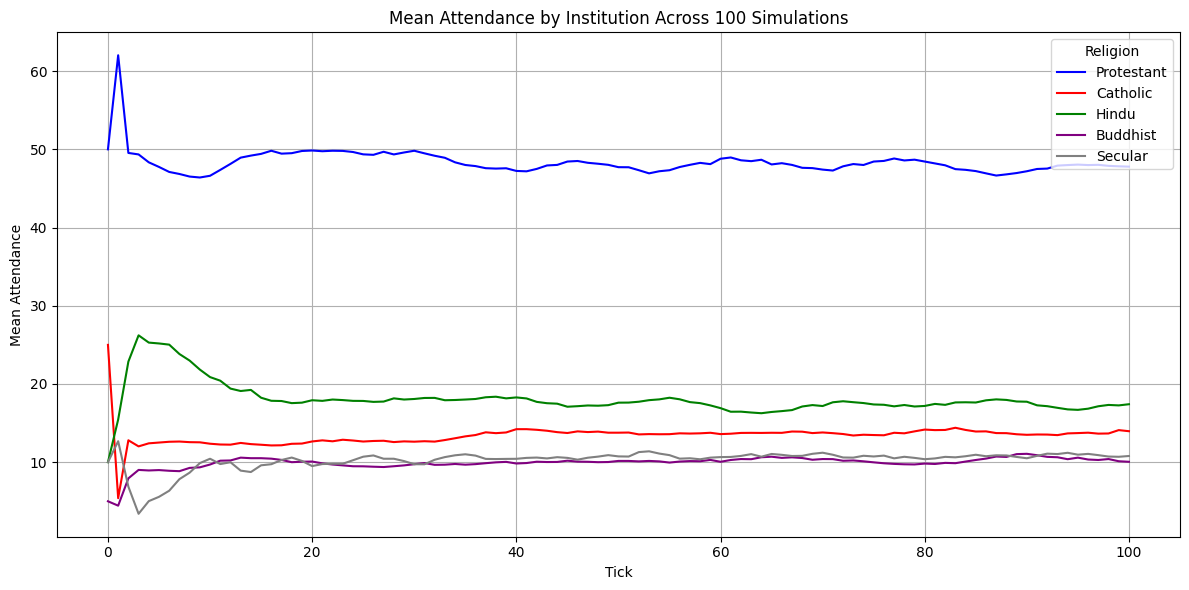

In [47]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                        # Total number of agents
d = 10                          # Memory window for strategies
num_ticks = 100                 # Number of ticks to simulate
inter_faith_connections = 20   # Number of edges added to the graph outside the institution network (a measure of religious pluralism / diversity)
network_type = "small_world"

# Initial population distribution and network configuration
initial_religious_dict = {
    "Protestant": {"N": 50, "Network Type": network_type},
    "Catholic": {"N": 25, "Network Type": network_type},
    "Hindu": {"N": 10, "Network Type": network_type},
    "Buddhist": {"N": 5, "Network Type": network_type},
    "Secular": {"N": 10, "Initial Connections": 5}
}

# Strategy distribution across the population
strategy_distribution = {
    "follow_majority": 0.125,
    "social_majority_recent": 0.125,
    "social_trend_following": 0.125,
    "peer_pressure_threshold": 0.125,
    "contrarian_follow_minority": 0.125,
    "contrarian_social_minority_recent": 0.125,
    "contrarian_trend": 0.125,
    "contrarian_peer_pressure": 0.125,
    "global_sheep": 0,
    "global_contrarian": 0,
    "independent_fixed": 0,
}

num_simulations = 100

# ------------------------------
# SIMULATION LOOP
# ------------------------------
all_attendance = []  # store each run's attendance

for sim in range(num_simulations):
    
    model = Model(
        N=N,
        d=d,
        initial_religious_dict=initial_religious_dict,
        strategy_distribution=strategy_distribution,
        inter_faith_connections=inter_faith_connections
    )
    
    model.run(num_ticks=num_ticks)

    # Grab results — indexed by tick
    attendance_df = model.get_results()
    all_attendance.append(attendance_df)

# ------------------------------
# AGGREGATE RESULTS
# ------------------------------

# Concatenate all runs along a new axis
attendance_concat = np.stack([df.values for df in all_attendance], axis=2)  # Shape: (ticks, religions, runs)

# Take the mean across runs (axis=2)
mean_attendance = np.mean(attendance_concat, axis=2)

# Rebuild into a DataFrame
mean_attendance_df = pd.DataFrame(mean_attendance, columns=all_attendance[0].columns, index=all_attendance[0].index)

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in mean_attendance_df.columns:
    plt.plot(mean_attendance_df.index, mean_attendance_df[religion], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Tick")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance by Institution Across 100 Simulations")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

## __Number of Religions and Initial Religious States__

### __1 Religion__

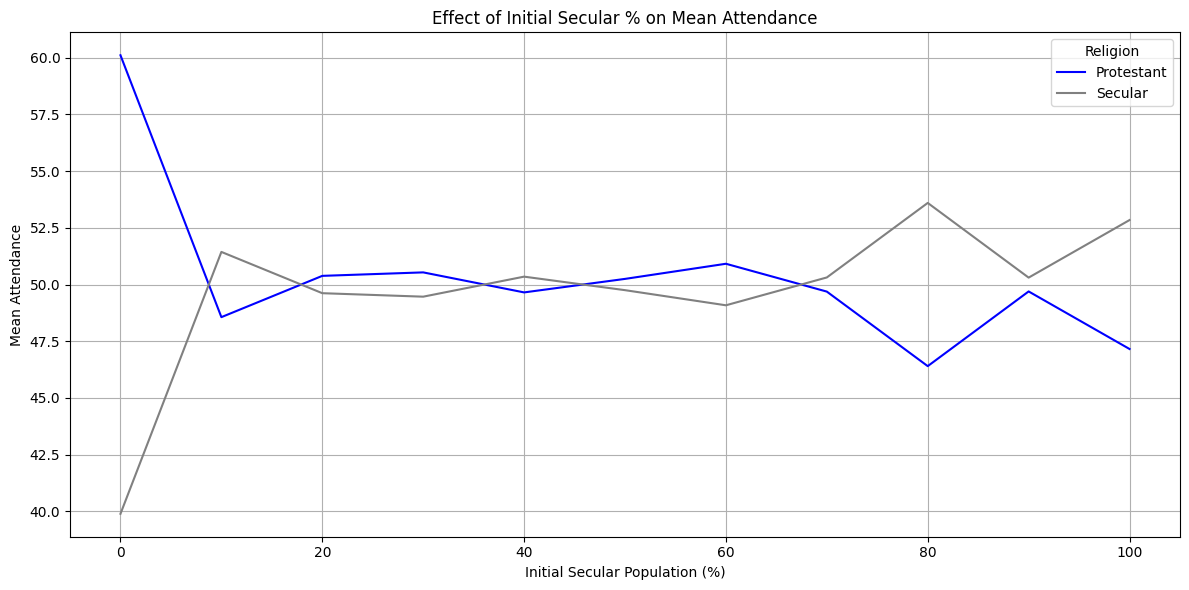

In [7]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                     # Total number of agents
d = 10                      # Memory window for strategies
num_ticks = 100             # Number of ticks to simulate
inter_faith_connections = 100  # No extra inter-faith edges
network_type = "small_world"

strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}

# ------------------------------
# SWEEP PARAMETERS
# ------------------------------
secular_counts = range(0, N + 1, 10)  # 0 to 100 secular in steps of 10
num_simulations_per_setting = 10

results = []

# ------------------------------
# SIMULATION LOOP
# ------------------------------
for num_secular in secular_counts:
    num_protestant = N - num_secular
    
    for sim in range(num_simulations_per_setting):
        # Set initial religious distribution
        initial_religious_dict = {
            "Protestant": {"N": num_protestant, "Network Type": network_type},
            "Secular": {"N": num_secular, "Initial Connections": 10}
        }
        
        # Create model
        model = Model(
            N=N,
            d=d,
            initial_religious_dict=initial_religious_dict,
            strategy_distribution=strategy_distribution,
            inter_faith_connections=inter_faith_connections
        )
        
        # Run model
        model.run(num_ticks=num_ticks)
        
        # Get  attendance
        attendance_df = model.get_results()
        
        # For each institution, calculate mean attendance over all ticks
        for religion in attendance_df.columns:
            mean_attendance = attendance_df[religion].mean()
            results.append({
                "Initial Secular %": (num_secular / N)*100,
                "Religion": religion,
                "Mean Attendance": mean_attendance
            })

# ------------------------------
# ORGANIZE RESULTS
# ------------------------------
results_df = pd.DataFrame(results)

# Average across trials
summary_df = results_df.groupby(["Initial Secular %", "Religion"]).mean().reset_index()

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in summary_df["Religion"].unique():
    subset = summary_df[summary_df["Religion"] == religion]
    plt.plot(subset["Initial Secular %"], subset["Mean Attendance"], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Initial Secular Population (%)")
plt.ylabel("Mean Attendance")
plt.title("Effect of Initial Secular % on Mean Attendance")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

### __2 Religions__

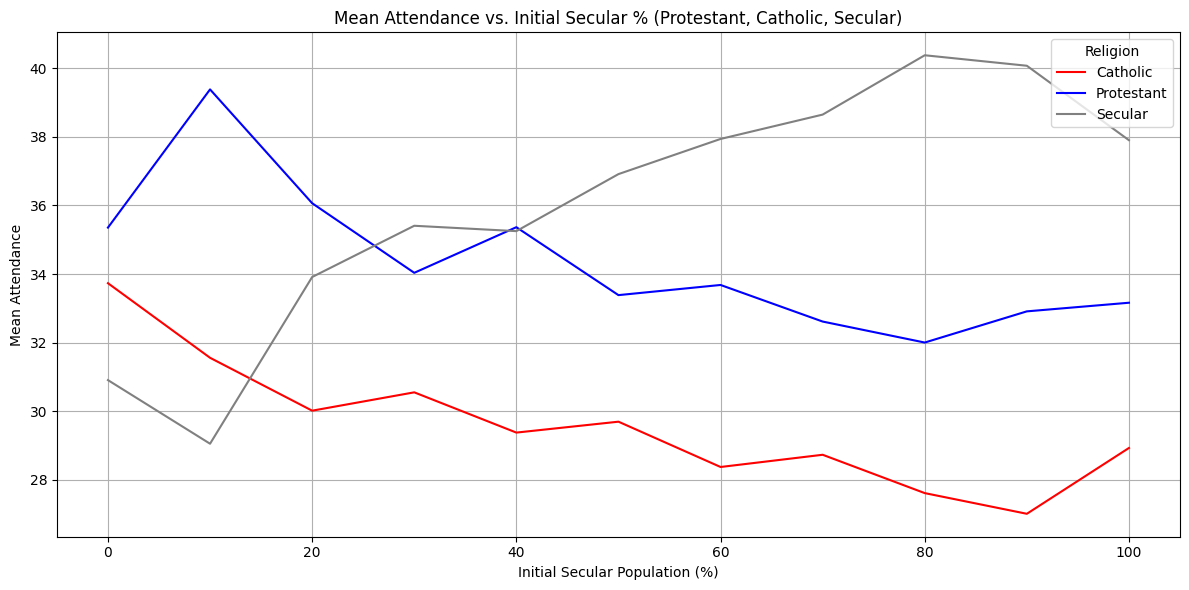

In [8]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                     # Total agents
d = 10                      # Memory window
num_ticks = 100              # Number of ticks
inter_faith_connections = 100  # No extra links
network_type = "small_world"

strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}

# ------------------------------
# SWEEP PARAMETERS
# ------------------------------
secular_counts = range(0, N + 1, 10)   # 0 → 100 secular agents
num_simulations_per_setting = 10

results = []

# ------------------------------
# SIMULATION LOOP
# ------------------------------
for num_secular in secular_counts:
    num_religious = N - num_secular
    
    # Even split Protestant/Catholic
    num_protestant = num_religious // 2
    num_catholic = num_religious - num_protestant  # Handle odd number

    for sim in range(num_simulations_per_setting):
        # Define initial religious setup
        initial_religious_dict = {
            "Protestant": {"N": num_protestant, "Network Type": network_type},
            "Catholic": {"N": num_catholic, "Network Type": network_type},
            "Secular": {"N": num_secular, "Initial Connections": 10}
        }

        # Create the model
        model = Model(
            N=N,
            d=d,
            initial_religious_dict=initial_religious_dict,
            strategy_distribution=strategy_distribution,
            inter_faith_connections=inter_faith_connections
        )

        # Run model
        model.run(num_ticks=num_ticks)

        # Get attendance data
        attendance_df = model.get_results()

        # Record mean attendance for each group
        for religion in attendance_df.columns:
            mean_attendance = attendance_df[religion].mean()
            results.append({
                "Initial Secular %": (num_secular / N)*100,
                "Religion": religion,
                "Mean Attendance": mean_attendance
            })

# ------------------------------
# ORGANIZE RESULTS
# ------------------------------
results_df = pd.DataFrame(results)

# Average across all runs
summary_df = results_df.groupby(["Initial Secular %", "Religion"]).mean().reset_index()

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in summary_df["Religion"].unique():
    subset = summary_df[summary_df["Religion"] == religion]
    plt.plot(subset["Initial Secular %"], subset["Mean Attendance"], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Initial Secular Population (%)")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance vs. Initial Secular % (Protestant, Catholic, Secular)")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


### __3 Religions__

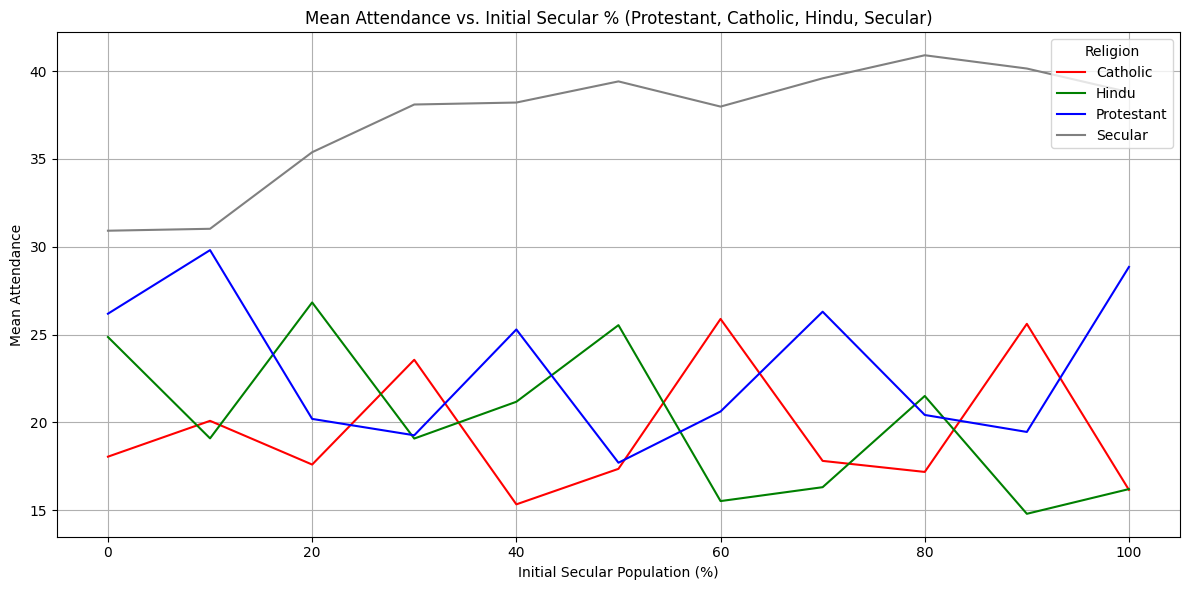

In [9]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100                     # Total agents
d = 10                      # Memory window
num_ticks = 100             # Number of ticks
inter_faith_connections = 100  # No extra links
network_type = "small_world"

strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}

# ------------------------------
# SWEEP PARAMETERS
# ------------------------------
secular_counts = range(0, N + 1, 10)   # From 0 to 100 secular agents
num_simulations_per_setting = 10

results = []

# ------------------------------
# SIMULATION LOOP
# ------------------------------
for num_secular in secular_counts:
    num_religious = N - num_secular

    # Evenly split religious into Protestant, Catholic, Hindu
    base = num_religious // 3
    remainder = num_religious % 3

    num_protestant = base
    num_catholic = base
    num_hindu = base

    # Distribute any remainder fairly
    if remainder > 0:
        num_protestant += 1
    if remainder > 1:
        num_catholic += 1
    # (If remainder == 2, Protestant and Catholic both get +1)

    for sim in range(num_simulations_per_setting):
        initial_religious_dict = {
            "Protestant": {"N": num_protestant, "Network Type": network_type},
            "Catholic": {"N": num_catholic, "Network Type": network_type},
            "Hindu": {"N": num_hindu, "Network Type": network_type},
            "Secular": {"N": num_secular, "Initial Connections": 10}
        }

        model = Model(
            N=N,
            d=d,
            initial_religious_dict=initial_religious_dict,
            strategy_distribution=strategy_distribution,
            inter_faith_connections=inter_faith_connections
        )

        model.run(num_ticks=num_ticks)

        attendance_df = model.get_results()

        for religion in attendance_df.columns:
            mean_attendance = attendance_df[religion].mean()
            results.append({
                "Initial Secular %": (num_secular / N)*100,
                "Religion": religion,
                "Mean Attendance": mean_attendance
            })

# ------------------------------
# ORGANIZE RESULTS
# ------------------------------
results_df = pd.DataFrame(results)

summary_df = results_df.groupby(["Initial Secular %", "Religion"]).mean().reset_index()

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in summary_df["Religion"].unique():
    subset = summary_df[summary_df["Religion"] == religion]
    plt.plot(subset["Initial Secular %"], subset["Mean Attendance"], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Initial Secular Population (%)")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance vs. Initial Secular % (Protestant, Catholic, Hindu, Secular)")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

### __4 Religions__

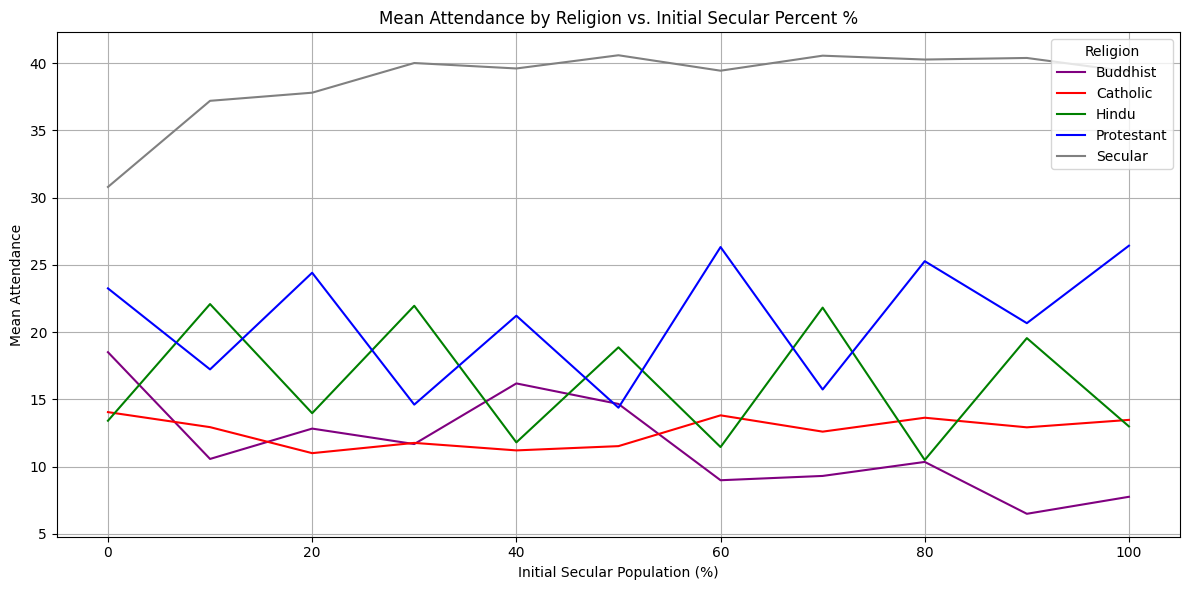

In [10]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100
d = 10
num_ticks = 100
network_type = "small_world"
inter_faith_connections = 100
num_simulations_per_setting = 10
secular_fractions = np.linspace(0, 1, 11)  # From 0.0 to 1.0 in 0.1 steps

strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}

results = []

# ------------------------------
# SIMULATION LOOP
# ------------------------------
for secular_fraction in secular_fractions:
    num_secular = int(N * secular_fraction)
    num_religious = N - num_secular

    # Evenly split religious population across Protestant, Catholic, Hindu, Buddhist
    if num_religious > 0:
        num_each_religion = num_religious // 4
        remainder = num_religious % 4  # Handle rounding

        religion_sizes = {
            "Protestant": num_each_religion,
            "Catholic": num_each_religion,
            "Hindu": num_each_religion,
            "Buddhist": num_each_religion,
        }

        # Distribute any remainder randomly
        religions = list(religion_sizes.keys())
        for i in range(remainder):
            religion_sizes[religions[i]] += 1
    else:
        # No religious people
        religion_sizes = {
            "Protestant": 0,
            "Catholic": 0,
            "Hindu": 0,
            "Buddhist": 0,
        }

    for sim in range(num_simulations_per_setting):
        initial_religious_dict = {
            "Protestant": {"N": religion_sizes["Protestant"], "Network Type": network_type},
            "Catholic": {"N": religion_sizes["Catholic"], "Network Type": network_type},
            "Hindu": {"N": religion_sizes["Hindu"], "Network Type": network_type},
            "Buddhist": {"N": religion_sizes["Buddhist"], "Network Type": network_type},
            "Secular": {"N": num_secular, "Initial Connections": 10},
        }

        model = Model(
            N=N,
            d=d,
            initial_religious_dict=initial_religious_dict,
            strategy_distribution=strategy_distribution,
            inter_faith_connections=inter_faith_connections
        )

        model.run(num_ticks=num_ticks)

        attendance_df = model.get_results()

        # For each institution, store mean attendance over all ticks
        for institution in attendance_df.columns:
            mean_attendance = attendance_df[institution].mean()
            results.append({
                "Initial Secular %": (num_secular / N)*100,
                "Religion": institution,
                "Mean Attendance": mean_attendance
            })

# ------------------------------
# ORGANIZE RESULTS
# ------------------------------
results_df = pd.DataFrame(results)

summary_df = results_df.groupby(["Initial Secular %", "Religion"]).mean().reset_index()

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in summary_df["Religion"].unique():
    subset = summary_df[summary_df["Religion"] == religion]
    plt.plot(subset["Initial Secular %"], subset["Mean Attendance"], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Initial Secular Population (%)")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance by Religion vs. Initial Secular Percent %")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


## __Network Types__

C:\Users\Kelby Mace\AppData\Local\Temp\ipykernel_17624\1032202972.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(religions, rotation=45, ha='right')
C:\Users\Kelby Mace\AppData\Local\Temp\ipykernel_17624\1032202972.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(religions, rotation=45, ha='right')


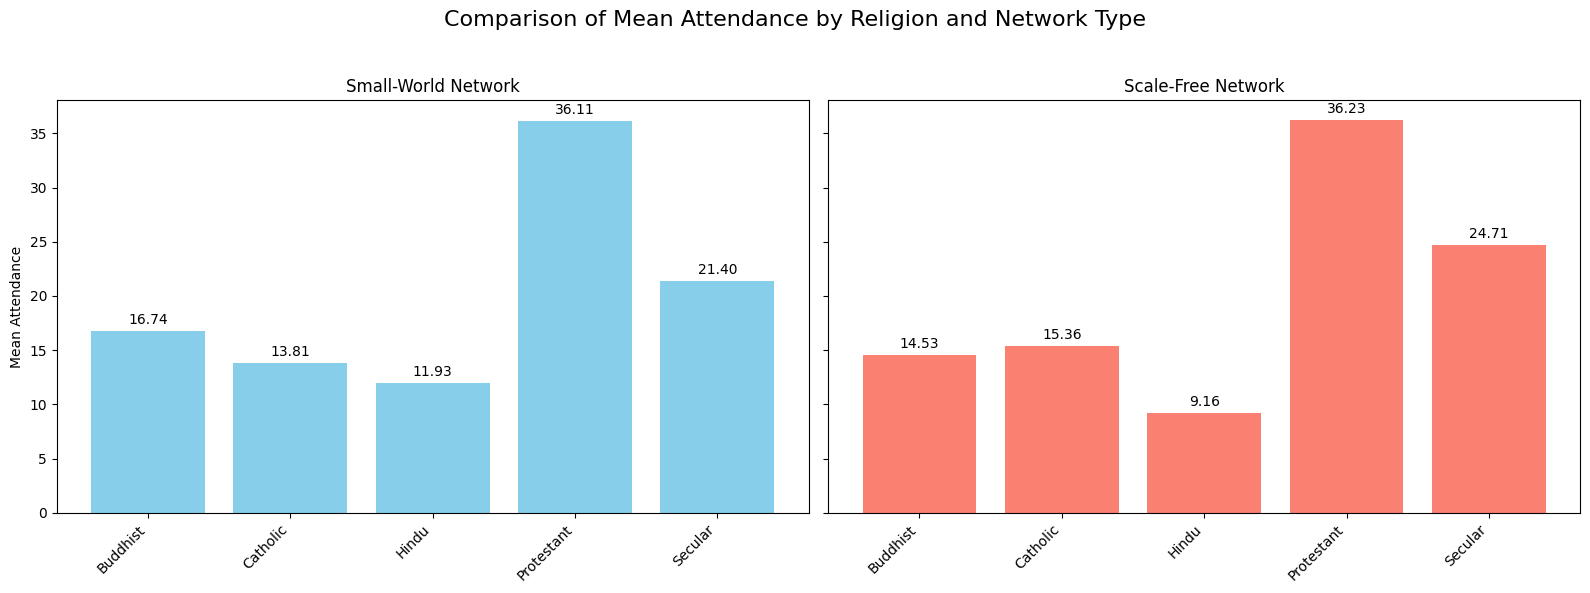

In [9]:
# ------------------------------
# PARAMETERS
# ------------------------------
N = 100
d = 10
num_ticks = 100
inter_faith_connections = 20  # Keep cross-institution ties at 0 for simplicity

# Strategy distribution (same as before)
strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}

# ------------------------------
# SIMULATION
# ------------------------------
network_types = ['small_world', 'scale_free']
num_simulations_per_network = 50
results = []

for network_type in network_types:
    for sim in range(num_simulations_per_network):
        initial_religious_dict = {
            "Protestant": {"N": 50, "Network Type": network_type},
            "Catholic": {"N": 25, "Network Type": network_type},
            "Hindu": {"N": 10, "Network Type": network_type},
            "Buddhist": {"N": 5, "Network Type": network_type},
            "Secular": {"N": 10, "Initial Connections": 5}
        }

        # Build and run model
        model = Model(
            N=N,
            d=d,
            initial_religious_dict=initial_religious_dict,
            strategy_distribution=strategy_distribution,
            inter_faith_connections=inter_faith_connections
        )

        model.run(num_ticks=num_ticks)

        # Get  attendance counts
        attendance_df = model.get_results()

        # Store results
        for religion in attendance_df.columns:
            mean_attendance = attendance_df[religion].mean()
            results.append({
                "Network Type": network_type,
                "Religion": religion,
                "Mean Attendance": mean_attendance
            })

# ------------------------------
# ORGANIZE RESULTS
# ------------------------------
results_df = pd.DataFrame(results)

# Group by Network Type and Religion, then average across trials
summary_df = results_df.groupby(["Network Type", "Religion"]).mean().reset_index()

# Split the data by network type
small_world_df = summary_df[summary_df["Network Type"] == "small_world"]
scale_free_df = summary_df[summary_df["Network Type"] == "scale_free"]

# Religions (ensure consistent ordering)
religions = sorted(summary_df["Religion"].unique())

# ------------------------------
# PLOT HISTOGRAMS
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot Small-World
bars1 = axes[0].bar(
    religions,
    small_world_df.set_index("Religion").loc[religions]["Mean Attendance"],
    color='skyblue'
)
axes[0].set_title("Small-World Network")
axes[0].set_ylabel("Mean Attendance")
axes[0].set_xticklabels(religions, rotation=45, ha='right')
axes[0].bar_label(bars1, fmt='%.2f', padding=3)

# Plot Scale-Free
bars2 = axes[1].bar(
    religions,
    scale_free_df.set_index("Religion").loc[religions]["Mean Attendance"],
    color='salmon'
)
axes[1].set_title("Scale-Free Network")
axes[1].set_xticklabels(religions, rotation=45, ha='right')
axes[1].bar_label(bars2, fmt='%.2f', padding=3)

# Final plot formatting
fig.suptitle("Comparison of Mean Attendance by Religion and Network Type", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the subtitle
plt.show()


No meanigful difference: N = 100 is not large enough for these differences to have much of an impact. "Hubs" don't really exist at this scale. Also most strategies only deal with neighbors (rather than larger network topology) and they treat all neighbors equally.

## __Inter-Faith Connections, Secular Connections__

### __Inter-Faith Connections__

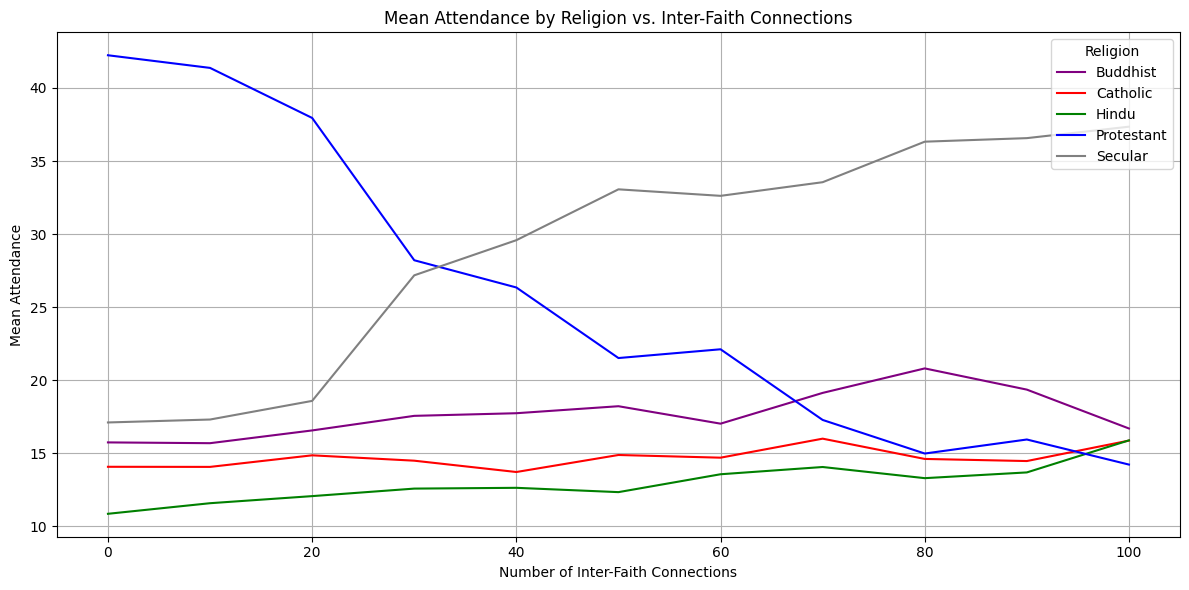

In [12]:
# ------------------------------
# PARAMETERS
# ------------------------------

N = 100
d = 10
num_ticks = 100
network_type = "small_world"

initial_religious_dict = {
    "Protestant": {"N": 50, "Network Type": network_type},
    "Catholic": {"N": 25, "Network Type": network_type},
    "Hindu": {"N": 10, "Network Type": network_type},
    "Buddhist": {"N": 5, "Network Type": network_type},
    "Secular": {"N": 10, "Initial Connections": 5}
}

strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}

# ------------------------------
# SWEEP PARAMETERS
# ------------------------------
inter_faith_values = np.linspace(0, 100, 11) # 11 values from 0 to 100
num_simulations_per_setting = 10

# Collect all results
results = []

# ------------------------------
# SIMULATION LOOP
# ------------------------------
for inter_faith_connections in inter_faith_values:
    for sim in range(num_simulations_per_setting):
        # Create a new model
        model = Model(
            N=N,
            d=d,
            initial_religious_dict=initial_religious_dict,
            strategy_distribution=strategy_distribution,
            inter_faith_connections=inter_faith_connections
        )

        # Run the model
        model.run(num_ticks=num_ticks)

        # Get  attendance counts
        attendance_df = model.get_results()

        # For each religion, compute the mean attendance over all ticks
        for religion in attendance_df.columns:
            # if religion == "tick":
            #     continue
            mean_attendance = attendance_df[religion].mean()
            results.append({
                "Inter-Faith Connections": inter_faith_connections,
                "Religion": religion,
                "Mean Attendance": mean_attendance
            })

# ------------------------------
# ORGANIZE RESULTS
# ------------------------------
results_df = pd.DataFrame(results)

# Average across runs
summary_df = results_df.groupby(["Inter-Faith Connections", "Religion"]).mean().reset_index()

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in summary_df["Religion"].unique():
    subset = summary_df[summary_df["Religion"] == religion]
    plt.plot(subset["Inter-Faith Connections"], subset["Mean Attendance"], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Number of Inter-Faith Connections")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance by Religion vs. Inter-Faith Connections")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

### __Secular Connections__

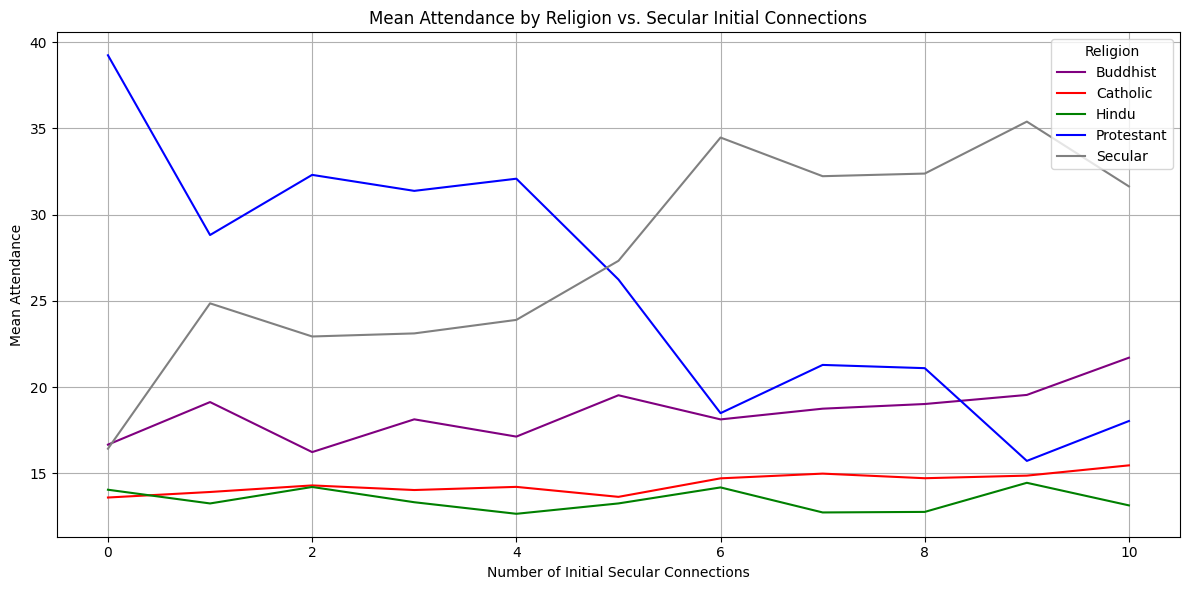

In [13]:
# ------------------------------
# PARAMETERS
# ------------------------------

N = 100
d = 10
num_ticks = 100
network_type = "small_world"
inter_faith_connections = 20

# Base configuration
base_initial_religious_dict = {
    "Protestant": {"N": 50, "Network Type": network_type},
    "Catholic": {"N": 25, "Network Type": network_type},
    "Hindu": {"N": 10, "Network Type": network_type},
    "Buddhist": {"N": 5, "Network Type": network_type},
    "Secular": {"N": 10, "Initial Connections": None}  # Change this for each run
}

strategy_distribution = {
    "follow_majority": 0.1,
    "social_majority_recent": 0.1,
    "social_trend_following": 0.1,
    "peer_pressure_threshold": 0.1,
    "contrarian_follow_minority": 0.1,
    "contrarian_social_minority_recent": 0.1,
    "contrarian_trend": 0.1,
    "contrarian_peer_pressure": 0.1,
    "global_sheep": 0.1,
    "global_contrarian": 0.1,
    "independent_fixed": 0,
}

# ------------------------------
# SWEEP PARAMETERS
# ------------------------------
secular_connection_values = np.arange(0, 11, 1)  # 0 to 10 secular initial connections
num_simulations_per_setting = 10

# Collect results
results = []

# ------------------------------
# SIMULATION LOOP
# ------------------------------
for secular_initial_connections in secular_connection_values:
    for sim in range(num_simulations_per_setting):

        # Apply secular coonections value
        initial_religious_dict["Secular"]["Initial Connections"] = secular_initial_connections

        # Create and run the model
        model = Model(
            N=N,
            d=d,
            initial_religious_dict=initial_religious_dict,
            strategy_distribution=strategy_distribution,
            inter_faith_connections=50  # Or whatever constant you want
        )

        model.run(num_ticks=num_ticks)

        # Get  attendance counts
        attendance_df = model.get_results()

        # For each religion, compute the mean attendance over all ticks
        for religion in attendance_df.columns:
            mean_attendance = attendance_df[religion].mean()
            results.append({
                "Secular Initial Connections": secular_initial_connections,
                "Religion": religion,
                "Mean Attendance": mean_attendance
            })

# ------------------------------
# ORGANIZE RESULTS
# ------------------------------
results_df = pd.DataFrame(results)

# Average across runs
summary_df = results_df.groupby(["Secular Initial Connections", "Religion"]).mean().reset_index()

# ------------------------------
# PLOT RESULTS
# ------------------------------
plt.figure(figsize=(12, 6))
religion_colors = {
    "Protestant": "blue",
    "Catholic": "red",
    "Hindu": "green",
    "Buddhist": "purple",
    "Secular": "gray"
}
for religion in summary_df["Religion"].unique():
    subset = summary_df[summary_df["Religion"] == religion]
    plt.plot(subset["Secular Initial Connections"], subset["Mean Attendance"], label=religion, color=religion_colors.get(religion, "black"))

plt.xlabel("Number of Initial Secular Connections")
plt.ylabel("Mean Attendance")
plt.title("Mean Attendance by Religion vs. Secular Initial Connections")
plt.legend(title="Religion", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


To my surprise, the model seems highly insensitive to both the number of inter-faith connections and the number of secular initial connections.

#### _References_

Arthur, W. B. (1994). "Inductive reasoning and bounded rationality." The American Economic Review, 84(2), 406-411.

I. Nan, "El Farol Simulator," GitHub repository, 2025. [Online]. Available: https://github.com/israelnan/El_Farol_bar_problem/blob/main/El_Farol_simulator.py
